In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
## STEPS:
#1. Load model
#2. load data
#3. Run inference on 1 sample
#4. Make a wrapper for using scikit learn
#5. Run inference on 1 sample using wrapper
#6. Run shap values using 1 example

In [ ]:
#!pip install lightning
#!pip install git+https://github.com/wfondrie/depthcharge.git
#!pip install --force-reinstall lance
#!pip install shap

In [ ]:
import os
os.chdir('/Users/sebas/projects/metabolomics')
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [5]:
ls ../data/

In [6]:
## Params
dataset_path = '../data/merged_gnps_nist_20240207_gnps_nist_janssen_15_millions.pkl'
best_model_path='../data/best_model_128n_10_layers_20240209.ckpt'

In [7]:
import shap
import matplotlib.pyplot as plt
from src.transformers.embedder import Embedder
from src.config import Config
import dill
from src.train_utils import TrainUtils
from src.transformers.load_data import LoadData
from src.molecular_pairs_set import MolecularPairsSet
from torch.utils.data import DataLoader
import lightning.pytorch as pl
from src.transformers.postprocessing import Postprocessing
import numpy as np
from src.transformers.sklearn_model import SklearnModel
import spectrum_utils.plot as sup

Seed set to 42


In [8]:
config=Config()

In [9]:
# 1. load model
best_model = Embedder.load_from_checkpoint(best_model_path, d_model=int(config.D_MODEL), n_layers=int(config.N_LAYERS))

In [10]:
best_model

Embedder(
  (linear): Linear(in_features=260, out_features=32, bias=True)
  (relu): ReLU()
  (linear_regression): Linear(in_features=32, out_features=1, bias=True)
  (spectrum_encoder): SpectrumTransformerEncoderCustom(
    (peak_encoder): PeakEncoder(
      (mz_encoder): FloatEncoder()
      (int_encoder): FloatEncoder()
      (combiner): Linear(in_features=256, out_features=128, bias=False)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-9): 10 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
          )
          (linear1): Linear(in_features=128, out_features=1024, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1024, out_features=128, bias=True)
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((128,), eps=1e-05,

## load data

In [11]:
# load data
# Load the dataset from the pickle file
with open(dataset_path, 'rb') as file:
    dataset = dill.load(file)

molecule_pairs_train = dataset['molecule_pairs_train']
molecule_pairs_val = dataset['molecule_pairs_val']
molecule_pairs_test= dataset['molecule_pairs_test']
uniformed_molecule_pairs_test = dataset['uniformed_molecule_pairs_test']

<Axes: xlabel='m/z', ylabel='Intensity'>

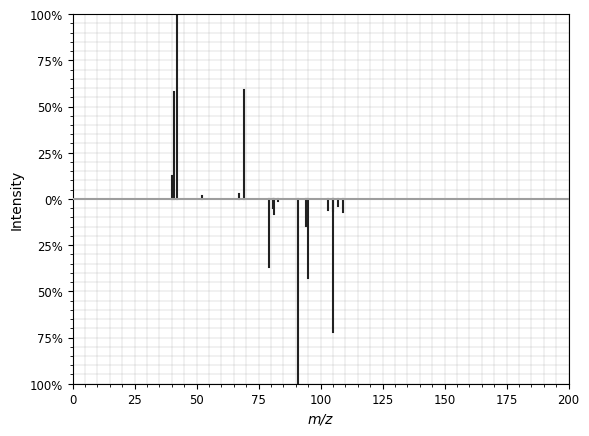

In [12]:
#plot one spectrum from molecule_pairs_test

sup.mirror(uniformed_molecule_pairs_test[0].spectrum_object_0, uniformed_molecule_pairs_test[0].spectrum_object_1)

In [13]:
len(uniformed_molecule_pairs_test)

185165

In [14]:
index = 0

In [15]:
one_molecule_pair  = MolecularPairsSet(spectrums=uniformed_molecule_pairs_test.spectrums, 
                                       indexes_tani = uniformed_molecule_pairs_test.indexes_tani[index:index+1,:])

In [16]:
one_molecule_pair

## Make a wrapper

In [17]:
sklearn_model = SklearnModel(best_model_path, d_model=int(config.D_MODEL), n_layers=int(config.N_LAYERS))

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [18]:
explainer=sklearn_model.get_explainer(uniformed_molecule_pairs_test)

Preprocessing all the data ...


32486it [00:01, 20667.30it/s]


Finished preprocessing 
Starting the loading of the data ...
Normalizing intensities
Creating dictionaries
Preprocessing all the data ...


32486it [00:00, 78841.50it/s]


Finished preprocessing 
Starting the loading of the data ...
Normalizing intensities
Creating dictionaries


## Target molecule pair

In [80]:
mol_gnps = uniformed_molecule_pairs_test.get_gnps_pairs()
mol_gnps = mol_gnps.filter_by_similarity(min_sim=1, max_sim=1)

In [81]:
len(mol_gnps)

274

In [168]:
index_gnps=14

In [169]:
print(mol_gnps[index_gnps])

Molecular pair with similarity: 1.0 for smiles_0: CCCCCCCC(NC(C(O)=O)C)=O and smiles_1: CCCCCCCCCCCCCCCCCCCC(NC(C(O)=O)C)=O


In [172]:
mol_gnps[index_gnps].spectrum_object_0.params['spectrumid'],mol_gnps[index_gnps].spectrum_object_1.params['spectrumid']

('CCMSLIB00011434959', 'CCMSLIB00011435578')

<Axes: xlabel='m/z', ylabel='Intensity'>

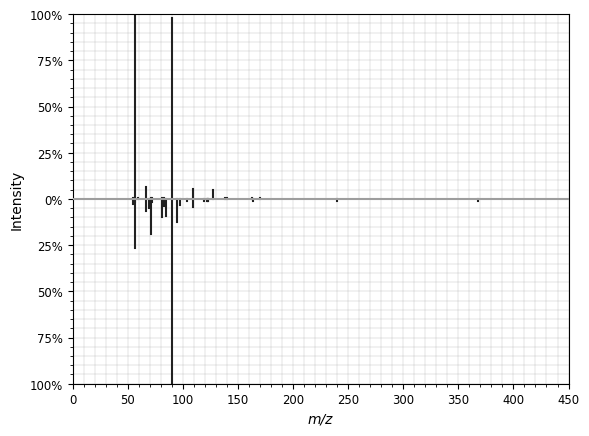

In [170]:
sup.mirror(mol_gnps[index_gnps].spectrum_object_0, mol_gnps[index_gnps].spectrum_object_1)

In [173]:
target_molecule_pair  = MolecularPairsSet(spectrums=mol_gnps.spectrums, 
                                       indexes_tani = mol_gnps.indexes_tani[index_gnps:index_gnps+1,:])

In [174]:
target_molecule_pair.indexes_tani

array([[8.4700e+03, 2.6292e+04, 1.0000e+00]])

## Compute shap

In [175]:
shap_values, X = sklearn_model.compute_shap_values(explainer, target_molecule_pair)

Preprocessing all the data ...


32486it [00:00, 77207.88it/s]


Finished preprocessing 
Starting the loading of the data ...
Normalizing intensities
Creating dictionaries
Prediction has been called


/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Prediction has been called


Predicting: |                                                                                                 …

Prediction has been called


Predicting: |                                                                                                 …

Prediction has been called


Predicting: |                                                                                                 …

Prediction has been called


Predicting: |                                                                                                 …

PermutationExplainer explainer: 2it [05:49, 349.27s/it]                                                                                                                                                             


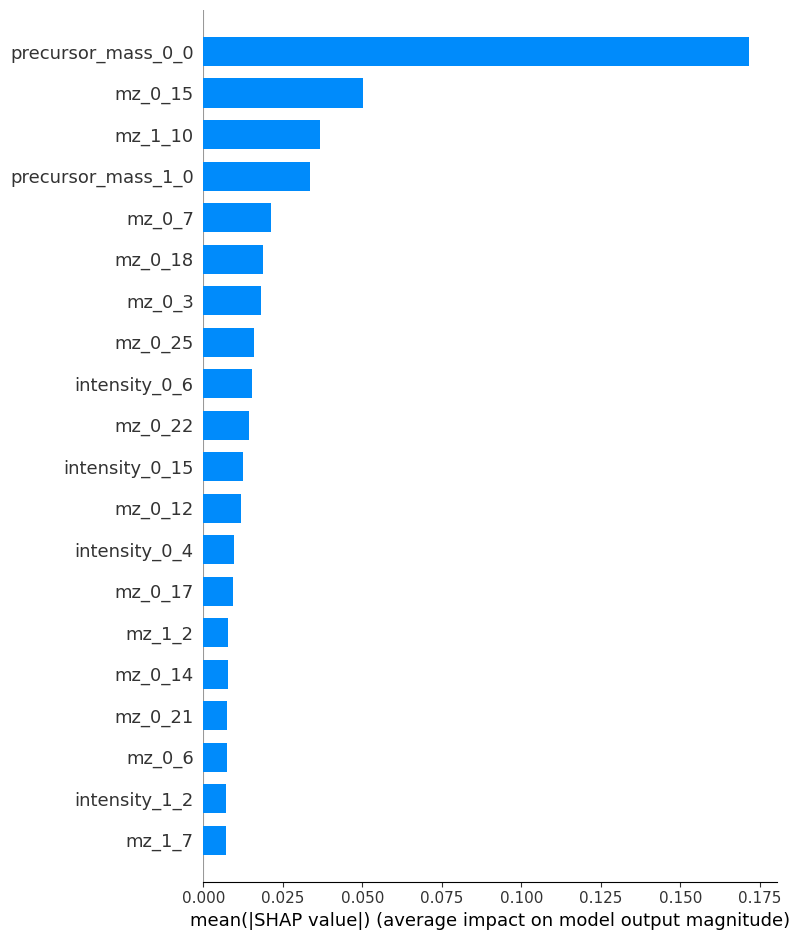

In [176]:
# Plot the SHAP summary plot
shap.summary_plot(shap_values, X, plot_type="bar")

In [177]:
spectrum_0 = target_molecule_pair.spectrums[int(target_molecule_pair.indexes_tani[0,0])]

In [178]:
spectrum_1 = target_molecule_pair.spectrums[int(target_molecule_pair.indexes_tani[0,1])]

In [179]:
len(spectrum_0.mz)

27

<Axes: xlabel='m/z', ylabel='Intensity'>

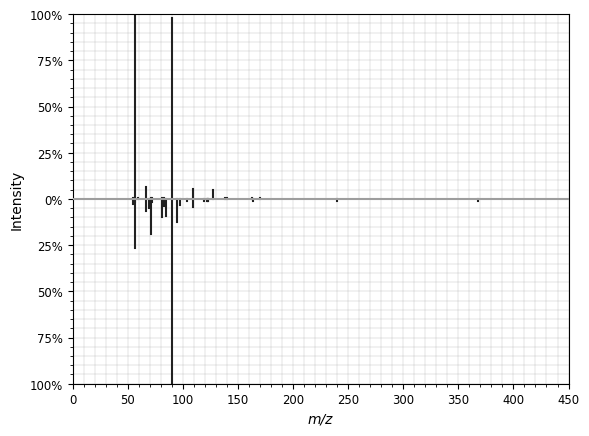

In [180]:
import spectrum_utils.plot as sup
sup.mirror(spectrum_0, spectrum_1)

In [181]:
len(spectrum_0.mz), len(spectrum_1.mz)

(27, 22)

In [182]:
def plot_peaks(mz, intensity, mark_indexes=[], xmin=0, xmax=250):
    plt.scatter(mz, intensity)
    
    for x,y in zip(mz, intensity):
        plt.vlines(x=x, ymin=0, ymax=y, color='g', linestyle=':', label='Vertical Line at x=4, y=4')
    for m in mark_indexes:
        plt.scatter(mz[m], intensity[m], marker='x', color='red', s=100)

    plt.xlim([xmin, xmax])
    plt.xlabel('mz')
    plt.ylabel('intensity')
    plt.grid()

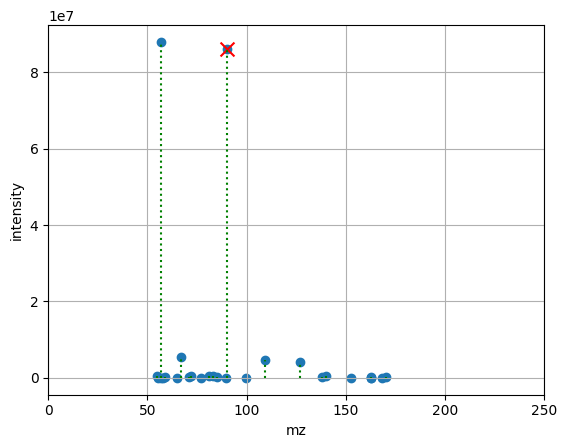

In [188]:
plot_peaks(spectrum_0.mz, spectrum_0.intensity, mark_indexes=[15])

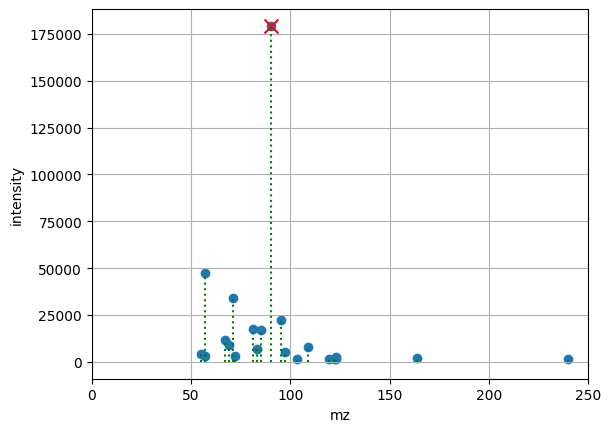

In [186]:
plot_peaks(spectrum_1.mz, spectrum_1.intensity, mark_indexes=[10])

In [189]:
spectrum_0.params

{'pepmass': (216.159, None),
 'charge': [1],
 'mslevel': '2',
 'source_instrument': 'ESI-Orbitrap',
 'filename': 'FernandaOl/CreepingFat/ECG_Acyl_amides/mzML_Acyl/P2_A5_54_C8_0.mzML',
 'seq': '*..*',
 'ionmode': 'Positive',
 'organism': 'ECG-ACYL-AMIDES-C4-C24-LIBRARY',
 'name': 'Ala-C8:0 M+H',
 'pi': 'Dorrestein',
 'datacollector': 'Ipsita',
 'smiles': 'CCCCCCCC(NC(C(O)=O)C)=O',
 'inchi': 'InChI=1S/C11H21NO3/c1-3-4-5-6-7-8-10(13)12-9(2)11(14)15/h9H,3-8H2,1-2H3,(H,12,13)(H,14,15)',
 'inchiaux': 'N/A',
 'pubmed': 'N/A',
 'submituser': 'jzemlin',
 'libraryquality': '1',
 'spectrumid': 'CCMSLIB00011434959',
 'scans': '1912'}